In [1]:
import sys
sys.path.append('../src/')
from vi_hrg import *
from utils import c2d, hyperdist, p_hd, polar2cart
from torch.distributions.bernoulli import Bernoulli

In [2]:
H = VI_HRG(20, 10)

In [3]:
num_nodes = 20
num_samples = 10
batch = 3
R_x = torch.tensor([1.,1.])
R = LogNormal(R_x[0], R_x[1]).rsample([batch])

In [4]:
T_x = torch.tensor([1.,1.]).exp()
T= Beta(T_x[0], T_x[1]).rsample([batch])

In [5]:
alpha_x = torch.tensor([1.,1.])
alpha = LogNormal(alpha_x[0], alpha_x[1]).rsample([batch])

In [6]:
edges = torch.tensor([1.,0.,1.])

In [7]:
from torch.distributions.uniform import Uniform
r_x_loc = Uniform(-1., 1.).rsample([num_nodes])
r_x_scale = Uniform(0.2, 1.2).rsample([num_nodes])

In [8]:
idx1, idx2 = torch.tensor([8, 12, 16]), torch.tensor([5, 3, 19])
#idx1, idx2 = torch.tensor([8,12]), torch.tensor([5,3])

In [9]:
r_i = Radius(r_x_loc[idx1], r_x_scale[idx1], R).rsample([num_samples])
r_j = Radius(r_x_loc[idx2], r_x_scale[idx2], R).rsample([num_samples])

In [10]:
r_x_loc

tensor([-0.4519,  0.5948, -0.7966,  0.8602, -0.0786,  0.1869,  0.5418,  0.0586,
         0.0055,  0.5377,  0.0321, -0.9018,  0.3245,  0.9110,  0.4106, -0.1272,
        -0.8668, -0.2763, -0.9732, -0.1890])

In [11]:
r_i

tensor([[1.4368, 1.5255, 1.8346],
        [1.1639, 1.0090, 1.3523],
        [1.1344, 1.3734, 1.3576],
        [1.6404, 1.6479, 2.0154],
        [0.9645, 1.5604, 1.8320],
        [1.2906, 1.3782, 1.8709],
        [1.3274, 1.4009, 1.8464],
        [1.1115, 1.4649, 2.4016],
        [1.0052, 1.5124, 1.4161],
        [0.9290, 1.2410, 1.9087]])

In [12]:
phi_x_loc = Uniform(-2.,2.).rsample([num_nodes, 2])
phi_x_scale = Uniform(0., 1.).rsample([num_nodes])

In [13]:
phi_x_scale[idx1].unsqueeze(dim=-1)

tensor([[0.2383],
        [0.7597],
        [0.6559]])

In [14]:
phi_i = VonMisesFisher(phi_x_loc[idx1], phi_x_scale[idx1].unsqueeze(dim=-1)).rsample(num_samples)
phi_j = VonMisesFisher(phi_x_loc[idx2], phi_x_scale[idx2].unsqueeze(dim=-1)).rsample(num_samples)

In [22]:
dist = hyperdist(r_i, r_j, c2d(phi_i), c2d(phi_j))
dist.shape

torch.Size([10, 3])

In [16]:
p_hd_ = lambda d,R,T: (1+((d-R)/(2*T)).exp()).reciprocal()

In [17]:
E_log_p_dist = p_hd(r_i, r_j, c2d(phi_i), c2d(phi_j), R, T).log().mean(dim=0)
E_log_p_dist_ = (1-p_hd(r_i, r_j, c2d(phi_i), c2d(phi_j), R, T)).log().mean(dim=0)

In [27]:
E_log_p_dist, E_log_p_dist_

(tensor([-0.7466, -0.1888, -0.4627]), tensor([-0.7469, -2.2811, -1.0874]))

In [28]:
log_pA = edges*E_log_p_dist + (1.-edges)*E_log_p_dist_
log_pA

tensor([-0.7466, -2.2811, -0.4627])

In [31]:
Bernoulli(p_hd_(dist, R, T)).log_prob(edges).mean(dim=0)

tensor([-0.7466, -2.2811, -0.4627])

In [44]:
(alpha*r_i).sinh().log().mean(dim=0).sum()

tensor(13.8530)

In [45]:
alpha.log().mean()

tensor(0.5053)

In [46]:
((alpha*R).cosh()-1).log().mean()

tensor(9.0174)

In [47]:
Radius(r_x_loc[idx1], r_x_scale[idx1], R).log_prob(r_i).mean(dim=0).sum()

tensor(-2.4310)

In [53]:
VonMisesFisher(phi_x_loc[idx1], phi_x_scale[idx1].unsqueeze(dim=-1)).log_prob(phi_i).mean(dim=0).sum()

tensor(-5.3182)

# Testing

In [1]:
import sys
sys.path.append('../src/')
from vi_hrg import *
from utils import c2d, hyperdist, p_hd, polar2cart
from torch import autograd

In [2]:
def noise_r(x, R, rel_var=0.1):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.where(rs>R, torch.ones(rs.size()).double()*R*0.999, rs)

In [3]:
def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

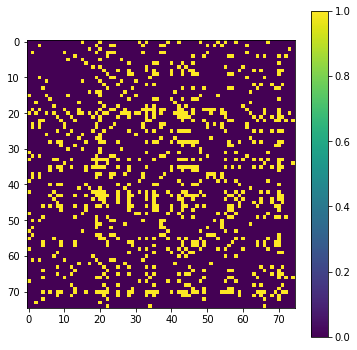

In [4]:
N = 75
G = HRG(R=torch.tensor([5.0]).double(),
            alpha=1.1,
            T=0.1)
r, theta, A = G.generate(N)
G.show()
#G.plot()

In [5]:
r_init = torch.stack((r, torch.rand([N]).double()), dim=-1)
phi_loc_init = torch.cat((polar2cart(1, noise_phi(theta, 0.02)),  torch.rand([N,1]).double()), dim=-1)
phi_loc_init.shape

torch.Size([75, 3])

In [6]:
dataloader = DataLoader(EdgesDataset(A), batch_size=64, shuffle=True, num_workers=0)
vi = VI_HRG(75,20, init_values={'rs':r_init, 
                              'phis_loc':phi_loc_init,
                              'phis_scale':None, 
                              'R':torch.tensor([0.5,-1.3]).double(), 
                              'T':torch.tensor([-2.3, 1.6]).double(),
                              'alpha':torch.tensor([0.1,-1.5]).double()})
vi.dataloader = dataloader
vi.optimizer = torch.optim.RMSprop(vi.parameters())

In [7]:
total_loss = 0
with autograd.detect_anomaly():
    print(torch.is_anomaly_enabled())
    for idx1, idx2, data in dataloader:
        loss = - vi.elbo(idx1, idx2, data)
        vi.optimizer.zero_grad()
        loss.backward()
        vi.optimizer.step()
        print('>>>>', loss)
        total_loss += loss

True


RuntimeError: Function 'ExpBackward' returned nan values in its 0th output.

In [ ]:
total_loss

In [11]:
#import torch
#dt = torch.float64
torch.ones([10]).to(f64)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)

In [10]:
from torch import float64 as f64

In [8]:
a = torch.ones([10,12,3])
a.select(-1,0).shape

torch.Size([10, 12])

In [12]:
torch.__version__

'1.4.0'

In [8]:
a = torch.rand([10,5])
a

tensor([[0.6734, 0.0017, 0.9958, 0.2378, 0.4747],
        [0.9169, 0.2611, 0.4543, 0.1213, 0.5338],
        [0.6214, 0.7093, 0.3063, 0.1091, 0.9549],
        [0.3568, 0.2072, 0.2858, 0.8559, 0.5453],
        [0.3146, 0.4877, 0.6244, 0.9430, 0.0779],
        [0.3158, 0.2597, 0.1527, 0.7620, 0.8136],
        [0.0155, 0.5623, 0.2989, 0.9388, 0.6620],
        [0.9988, 0.1019, 0.4559, 0.0680, 0.3892],
        [0.1888, 0.1531, 0.8277, 0.4921, 0.8323],
        [0.2748, 0.3178, 0.7365, 0.5047, 0.7009]])

In [11]:
b = torch.arange(5)

In [12]:
a*b

tensor([[0.0000e+00, 1.6751e-03, 1.9916e+00, 7.1339e-01, 1.8987e+00],
        [0.0000e+00, 2.6106e-01, 9.0856e-01, 3.6383e-01, 2.1350e+00],
        [0.0000e+00, 7.0928e-01, 6.1263e-01, 3.2728e-01, 3.8197e+00],
        [0.0000e+00, 2.0719e-01, 5.7161e-01, 2.5676e+00, 2.1813e+00],
        [0.0000e+00, 4.8774e-01, 1.2488e+00, 2.8290e+00, 3.1172e-01],
        [0.0000e+00, 2.5968e-01, 3.0545e-01, 2.2859e+00, 3.2542e+00],
        [0.0000e+00, 5.6234e-01, 5.9778e-01, 2.8164e+00, 2.6479e+00],
        [0.0000e+00, 1.0189e-01, 9.1171e-01, 2.0414e-01, 1.5569e+00],
        [0.0000e+00, 1.5307e-01, 1.6554e+00, 1.4764e+00, 3.3292e+00],
        [0.0000e+00, 3.1784e-01, 1.4729e+00, 1.5142e+00, 2.8037e+00]])

In [9]:
torch.min(r, torch.ones_like(r)*3.-1e-3)

tensor([2.8883, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990,
        0.5574, 2.9990, 2.9990, 2.9990, 2.6082, 2.9990, 2.9990, 2.9990, 2.9990,
        2.9990, 2.9990, 2.4347, 2.9990, 2.9990, 2.9990, 2.0568, 2.9990, 2.9990,
        1.8514, 2.9990, 2.9990, 2.9990, 1.4930, 2.9990, 2.9990, 1.8284, 2.9990,
        2.9866, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990,
        2.9990, 2.9990, 2.9990, 0.5375, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990,
        2.9990, 2.9990, 1.7859, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990,
        2.9990, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990, 2.9990,
        2.9990, 2.9990, 2.9990], dtype=torch.float64)

In [12]:
np.log(np.inf)

inf

In [9]:
torch.tensor([150.]).sinh()

tensor([inf])

In [8]:
r

tensor([4.0195, 4.6416, 4.5959, 4.2470, 3.7882, 1.6247, 4.0990, 4.0164, 3.9044,
        3.2931, 4.7525, 4.3722, 4.6446, 4.7307, 4.4867, 1.6073, 4.0229, 4.4086,
        4.3601, 4.2768, 3.6343, 3.2545, 4.9198, 4.8864, 4.1835, 3.3329, 4.1053,
        3.2045, 4.6782, 4.9149, 1.6893, 1.4627, 4.8743, 4.6637, 2.8160, 4.6776,
        4.8574, 2.7820, 2.8002, 4.9979, 4.4138, 3.7937, 4.2739, 4.1103, 4.7860,
        4.1406, 4.0478, 4.9866, 4.6020, 2.0940, 4.4668, 4.3581, 3.4521, 2.7487,
        4.0555, 4.6418, 3.6442, 4.4835, 3.8816, 4.0498, 2.7114, 4.7740, 4.4235,
        4.1105, 3.8298, 4.4490, 4.3148, 4.8179, 4.6985, 3.2842, 4.9939, 4.9189,
        4.8286, 3.6159, 3.9963], dtype=torch.float64)